**Course:** Neural Computing and Deep Learning
---
**Title:** Project 4
---
**Mahdi Mirfendereski - 401131065**
---


# Libraries

In [51]:
import numpy as np
import math
import json
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
import random
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
import tensorflow.keras as keras
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Datasets

In [18]:
data_dir_test ='../Inputs/Linnaeus5_data/test'     
data_dir_train ='../Inputs/Linnaeus5_data/train'     
data_dir_val ='../Inputs/Linnaeus5_data/val'     

train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir_train,
seed=123,
image_size=(128, 128),
batch_size=32)

valid_ds = tf.keras.utils.image_dataset_from_directory(
data_dir_val,
seed=123,
image_size=(128, 128),
batch_size=32)
 
test_ds = tf.keras.utils.image_dataset_from_directory(
data_dir_test,
seed=123,
image_size=(128, 128),
batch_size=32)

Found 5400 files belonging to 5 classes.
Found 600 files belonging to 5 classes.
Found 2000 files belonging to 5 classes.


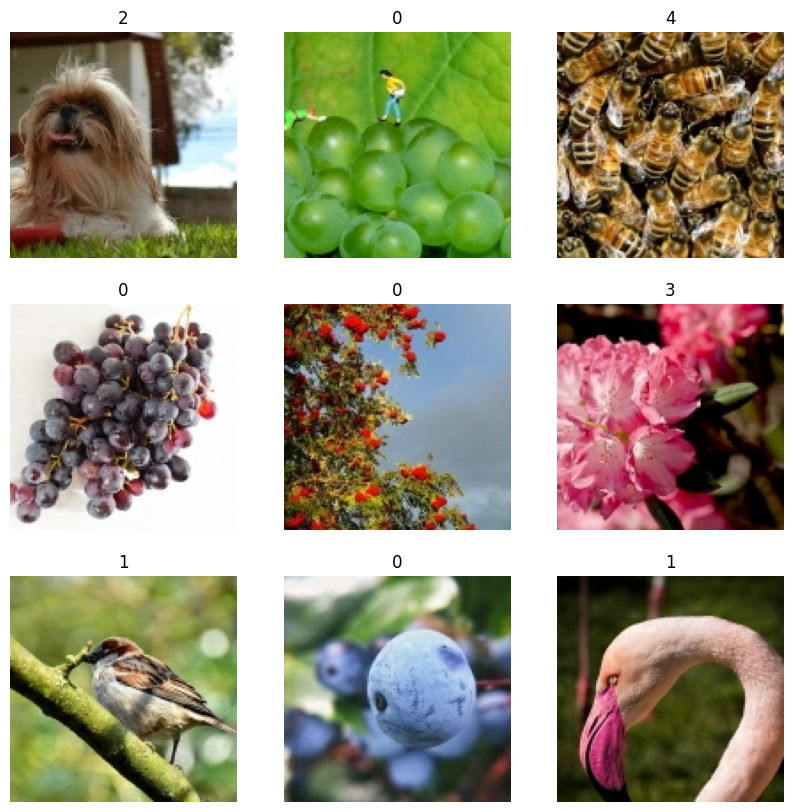

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break
train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 1) 

In [21]:
kernel_numbers = [16, 32, 64, 128]
kernel_sizes = [3, 5, 7]
strides = [1, 2]
pooling_approach = ['avg', 'max']
pool_sizes = [2, 3]
hidden_layer = [128, 256]


def sublists(l): 
  sublist = [] 
  for se in list(set(itertools.combinations(l, 3)) | set(itertools.combinations(l, 4)) ):
    sublist.append(list(se))
  return sublist

kernel_lists = sublists(kernel_numbers)

print(kernel_lists)
hyper_params = []
for ks in kernel_sizes:
    for stride in strides:
      for pool_app in pooling_approach:
        for ps in pool_sizes:
          for hid in hidden_layer:
            for kernel_list in kernel_lists:
              hyper_params.append({
                'kernel_numbers' : kernel_list,
                'kernel_size' : ks,
                'strides' : stride,
                'padding' : 'same',
                'activation' : 'relu',
                'pooling_app' : pool_app,
                'pool_size' : ps,
                'hidden_layer' : hid   
                }
              )


# print(hyper_params)
len(hyper_params)


[[16, 32, 64], [16, 64, 128], [16, 32, 128], [32, 64, 128], [16, 32, 64, 128]]


240

In [22]:

def train_cnn(kernel_numbers, kernel_size, strides, padding, activation, pooling_app, pool_size, hidden_layer, dropout_enable,verbose):
    es_callback = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    model = Sequential()
    model.add(Input((128, 128, 3,), name="Input"))
    model.add(tf.keras.layers.Rescaling(1./255))
    layer_counter = 1
    for kernel_item in kernel_numbers:
      ## conv
      conv2D = Conv2D(kernel_item, kernel_size=kernel_size, strides=(stride, stride), activation=activation, name="Conv_"+str(layer_counter), padding=padding)
      model.add(conv2D)

      ## drop
      if dropout_enable:
        model.add(Dropout(rate=0.5, name="Drop_"+str(layer_counter)))
      
      ## pooling
      if pooling_app == 'avg':
        model.add(AveragePooling2D(pool_size=(pool_size, pool_size), name="Pool_"+str(layer_counter)))
      elif pooling_app == 'max':
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size), name="Pool_"+str(layer_counter)))
      
      layer_counter += 1

    model.add(Flatten(name="Flat"))

    model.add(Dense(hidden_layer, activation="relu", name="Dense"))

    model.add(Dense(5, activation="softmax", name="Output"))

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history = model.fit(train_ds, validation_data=valid_ds, epochs=75, callbacks=[es_callback],verbose=verbose)
    # model.summary()

    return model,history,es_callback.stopped_epoch

In [8]:
counter = 1

temp_results = ''
for hyper in hyper_params:
    # print(counter)
    # if counter >3 :
    #     break
    kernel_numbers = hyper['kernel_numbers']
    kernel_size = hyper['kernel_size']
    strides = hyper['strides']
    padding = hyper['padding']
    activation = hyper['activation']
    pooling_app = hyper['pooling_app']
    pool_size = hyper['pool_size']
    hidden_layer = hyper['hidden_layer']    
    dropout_enable = False
    verbose = 0
    try:

        model, history, stopped_epoch = train_cnn(kernel_numbers, kernel_size, strides, padding, activation, pooling_app, pool_size, hidden_layer, dropout_enable,verbose)

        train_accu = model.evaluate(train_ds, verbose=verbose)[1]
        valid_accu = model.evaluate(valid_ds, verbose=verbose)[1]
        test_accu = model.evaluate(test_ds, verbose=verbose)[1]
        temp_res = f'kernel_numbers: {kernel_numbers}, kernel_size: {kernel_size}, strides: {strides}, padding: {padding}, activation: {activation}, pooling_app: {pooling_app}, pool_size: {pool_size}, hidden_layer: {hidden_layer}, dropout_enable: {dropout_enable}, train_accuracy = {round(train_accu*100, 2)}, validation_accuracy = {round(valid_accu*100, 2)}, test_accuracy = {round(test_accu*100, 2)}' 
        print(temp_res)
        temp_results += temp_res + '\n'
        if counter%15 == 0:
            with open("Q1_results.txt", "a") as f:
                f.write(temp_results)
                temp_results = ''    
        counter += 1

    except:
        continue




kernel_numbers: [16, 32, 64], kernel_size: 3, strides: 1, padding: same, activation: relu, pooling_app: avg, pool_size: 2, hidden_layer: 128, dropout_enable: False, train_accuracy = 74.07, validation_accuracy = 64.5, test_accuracy = 63.55
kernel_numbers: [16, 64, 128], kernel_size: 3, strides: 1, padding: same, activation: relu, pooling_app: avg, pool_size: 2, hidden_layer: 128, dropout_enable: False, train_accuracy = 76.39, validation_accuracy = 64.17, test_accuracy = 65.4
kernel_numbers: [16, 32, 128], kernel_size: 3, strides: 1, padding: same, activation: relu, pooling_app: avg, pool_size: 2, hidden_layer: 128, dropout_enable: False, train_accuracy = 78.85, validation_accuracy = 67.0, test_accuracy = 64.55
kernel_numbers: [32, 64, 128], kernel_size: 3, strides: 1, padding: same, activation: relu, pooling_app: avg, pool_size: 2, hidden_layer: 128, dropout_enable: False, train_accuracy = 74.11, validation_accuracy = 66.33, test_accuracy = 63.9
kernel_numbers: [16, 32, 64], kernel_size

Epoch 1/75
169/169 [==============================] - 2s 10ms/step - loss: 1.4742 - accuracy: 0.3117 - val_loss: 1.4409 - val_accuracy: 0.3500
Epoch 2/75
169/169 [==============================] - 1s 7ms/step - loss: 1.3053 - accuracy: 0.4357 - val_loss: 1.1599 - val_accuracy: 0.5000
Epoch 3/75
169/169 [==============================] - 1s 8ms/step - loss: 1.1794 - accuracy: 0.5046 - val_loss: 1.0688 - val_accuracy: 0.5383
Epoch 4/75
169/169 [==============================] - 1s 7ms/step - loss: 1.1148 - accuracy: 0.5374 - val_loss: 0.9829 - val_accuracy: 0.5900
Epoch 5/75
169/169 [==============================] - 1s 7ms/step - loss: 1.0546 - accuracy: 0.5707 - val_loss: 1.0108 - val_accuracy: 0.5833
Epoch 6/75
169/169 [==============================] - 1s 7ms/step - loss: 1.0022 - accuracy: 0.5970 - val_loss: 1.0177 - val_accuracy: 0.6017
Epoch 7/75
169/169 [==============================] - 1s 7ms/step - loss: 0.9491 - accuracy: 0.6181 - val_loss: 0.9026 - val_accuracy: 0.6333
Epoch

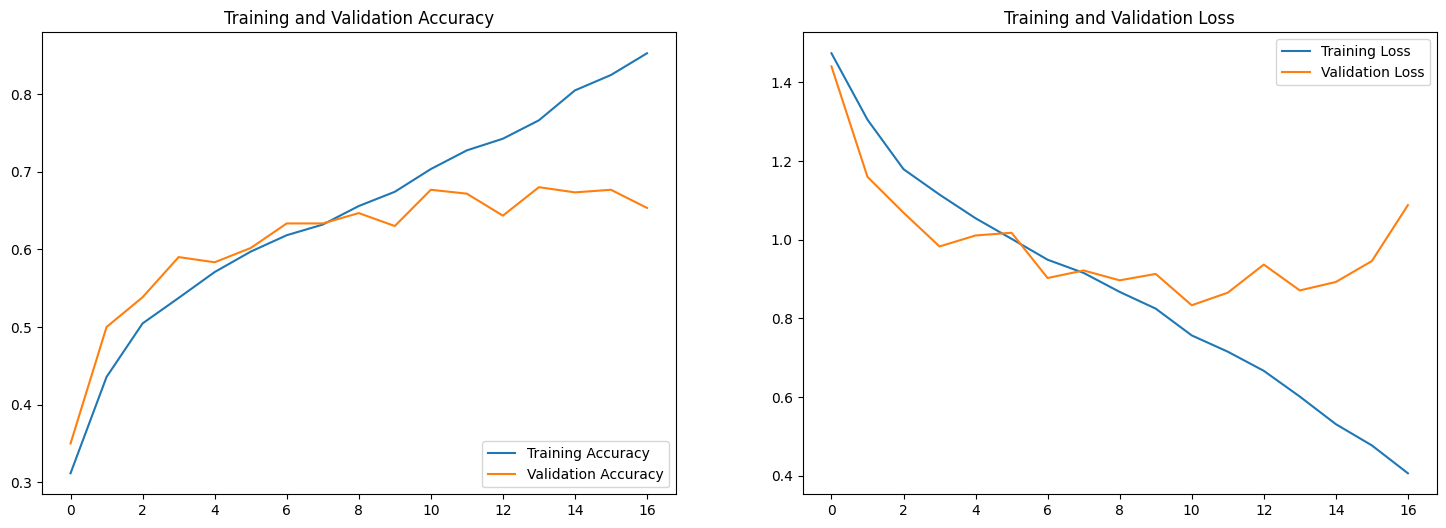

19/19 [==============================] - 0s 4ms/step


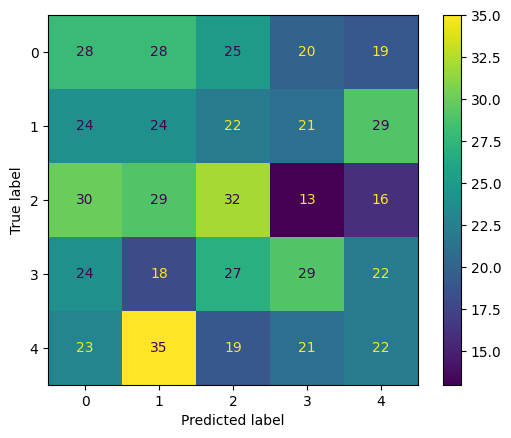

In [73]:
kernel_numbers = [16, 32, 128]
kernel_size = 5
strides = 2
padding = 'same'
activation = 'relu'
pooling_app = 'avg'
pool_size = 2
hidden_layer = 128
dropout_enable = False
verbose = 1
model_1, history_1, stopped_epoch = train_cnn(kernel_numbers, kernel_size, strides, padding, activation, pooling_app, pool_size, hidden_layer, dropout_enable,verbose)


train_accu = model_1.evaluate(train_ds, verbose=verbose)[1]
valid_accu = model_1.evaluate(valid_ds, verbose=verbose)[1]
test_accu = model_1.evaluate(test_ds, verbose=verbose)[1]
temp_res = f'kernel_numbers: {kernel_numbers}, kernel_size: {kernel_size}, strides: {strides}, padding: {padding}, activation: {activation}, pooling_app: {pooling_app}, pool_size: {pool_size}, hidden_layer: {hidden_layer}, dropout_enable: {dropout_enable}, train_accuracy = {round(train_accu*100, 2)}, validation_accuracy = {round(valid_accu*100, 2)}, test_accuracy = {round(test_accu*100, 2)}' 
print(temp_res) 

acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(stopped_epoch+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


valid_labels =  np.array([])
for _, label_batch in valid_ds:
    valid_labels = np.concatenate([valid_labels, label_batch])


pred_1 = model_1.predict(valid_ds)
pred_1 = pred_1.argmax(axis=1)
cm = confusion_matrix(valid_labels, pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



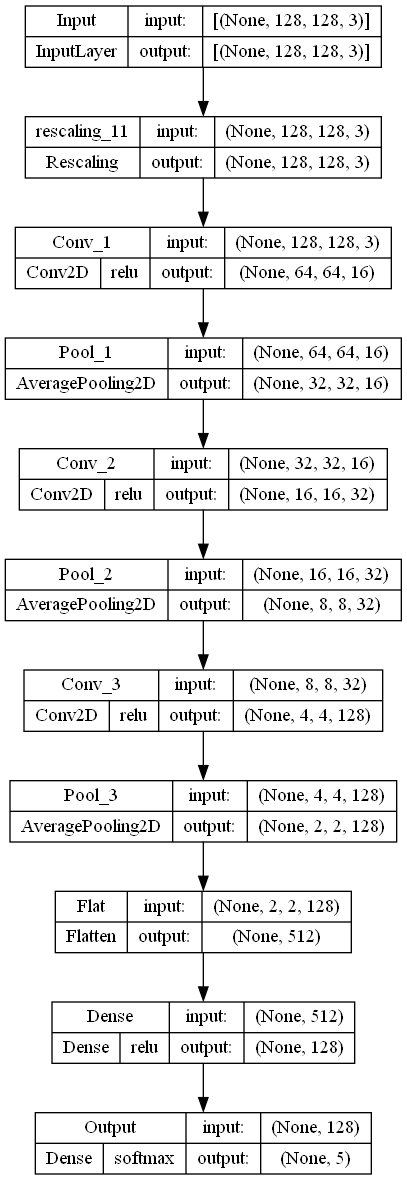

In [74]:
keras.utils.plot_model(model_1, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Epoch 1/75
169/169 [==============================] - 2s 8ms/step - loss: 1.4943 - accuracy: 0.3170 - val_loss: 1.3162 - val_accuracy: 0.3950
Epoch 2/75
169/169 [==============================] - 1s 7ms/step - loss: 1.2191 - accuracy: 0.4811 - val_loss: 1.1185 - val_accuracy: 0.5083
Epoch 3/75
169/169 [==============================] - 1s 7ms/step - loss: 1.1027 - accuracy: 0.5437 - val_loss: 1.0811 - val_accuracy: 0.5300
Epoch 4/75
169/169 [==============================] - 1s 7ms/step - loss: 0.9894 - accuracy: 0.5980 - val_loss: 1.0786 - val_accuracy: 0.5550
Epoch 5/75
169/169 [==============================] - 1s 7ms/step - loss: 0.9237 - accuracy: 0.6257 - val_loss: 0.9386 - val_accuracy: 0.6233
Epoch 6/75
169/169 [==============================] - 1s 7ms/step - loss: 0.8514 - accuracy: 0.6574 - val_loss: 0.9323 - val_accuracy: 0.6333
Epoch 7/75
169/169 [==============================] - 1s 7ms/step - loss: 0.7646 - accuracy: 0.6946 - val_loss: 0.9131 - val_accuracy: 0.6417
Epoch 

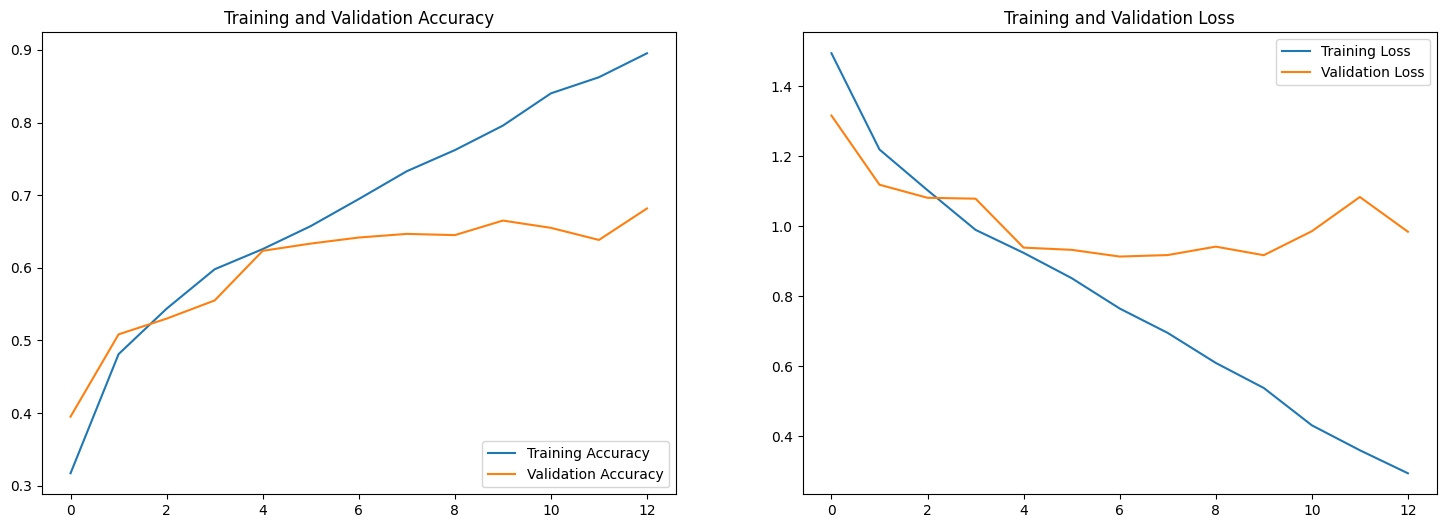

19/19 [==============================] - 0s 4ms/step


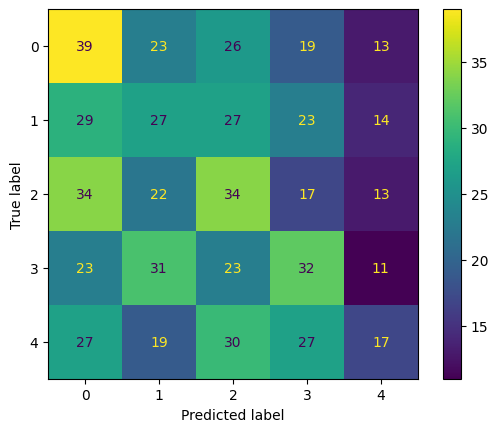

In [75]:
kernel_numbers = [16, 64, 128]
kernel_size = 3
strides = 2
padding = 'same'
activation = 'relu'
pooling_app = 'max'
pool_size = 2
hidden_layer = 256
dropout_enable = False
verbose = 1


model_2, history_2, stopped_epoch = train_cnn(kernel_numbers, kernel_size, strides, padding, activation, pooling_app, pool_size, hidden_layer, dropout_enable,verbose)


train_accu = model_2.evaluate(train_ds, verbose=verbose)[1]
valid_accu = model_2.evaluate(valid_ds, verbose=verbose)[1]
test_accu = model_2.evaluate(test_ds, verbose=verbose)[1]
temp_res = f'kernel_numbers: {kernel_numbers}, kernel_size: {kernel_size}, strides: {strides}, padding: {padding}, activation: {activation}, pooling_app: {pooling_app}, pool_size: {pool_size}, hidden_layer: {hidden_layer}, dropout_enable: {dropout_enable}, train_accuracy = {round(train_accu*100, 2)}, validation_accuracy = {round(valid_accu*100, 2)}, test_accuracy = {round(test_accu*100, 2)}' 
print(temp_res) 

acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(stopped_epoch+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


valid_labels =  np.array([])
for _, label_batch in valid_ds:
    valid_labels = np.concatenate([valid_labels, label_batch])


pred_2 = model_2.predict(valid_ds)
pred_2 = pred_2.argmax(axis=1)
cm = confusion_matrix(valid_labels, pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()



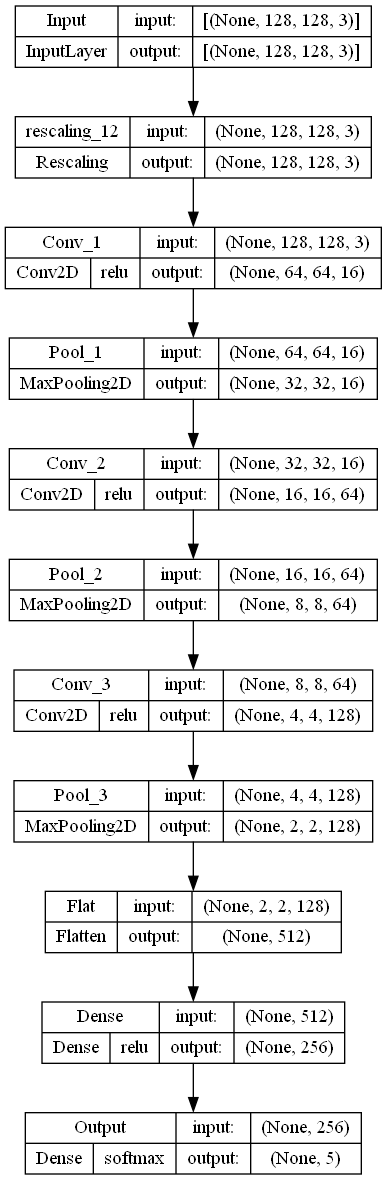

In [76]:
keras.utils.plot_model(model_2, show_layer_activations=True, show_shapes=True, show_layer_names=True)

# 2) 

# 3) 

In [97]:
for i in range(len(model_1.layers)):
    layer = model_1.layers[i]
    if 'conv' not in layer.name.lower():
        continue    
    print(i , layer.name , layer.output.shape)
for layer in model_1.layers:
    
    if 'conv' not in layer.name.lower():
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)    
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)    
filters

1 Conv_1 (None, 64, 64, 16)
3 Conv_2 (None, 16, 16, 32)
5 Conv_3 (None, 4, 4, 128)
Conv_1 (5, 5, 3, 16)
Conv_2 (5, 5, 16, 32)
Conv_3 (5, 5, 32, 128)


array([[[[0.6348519 , 0.57370865, 0.5298391 , ..., 0.6074643 ,
          0.52397144, 0.51206607],
         [0.5263841 , 0.57264864, 0.5664276 , ..., 0.734     ,
          0.5197352 , 0.5406457 ],
         [0.5863317 , 0.547823  , 0.5341555 , ..., 0.6019567 ,
          0.5779775 , 0.5075557 ],
         ...,
         [0.65917236, 0.55908644, 0.526881  , ..., 0.5068532 ,
          0.6113912 , 0.4424954 ],
         [0.6446367 , 0.57455075, 0.6124939 , ..., 0.6325782 ,
          0.59612966, 0.56588125],
         [0.53060263, 0.593091  , 0.54284436, ..., 0.5005807 ,
          0.44202712, 0.46486664]],

        [[0.5606855 , 0.51170564, 0.5777218 , ..., 0.6208304 ,
          0.4941154 , 0.57695   ],
         [0.6324223 , 0.4879994 , 0.5671907 , ..., 0.7130425 ,
          0.515907  , 0.49853888],
         [0.6234555 , 0.5854447 , 0.55684626, ..., 0.5764925 ,
          0.56550676, 0.4626943 ],
         ...,
         [0.47409713, 0.578226  , 0.55633485, ..., 0.58924085,
          0.52690065, 0.5

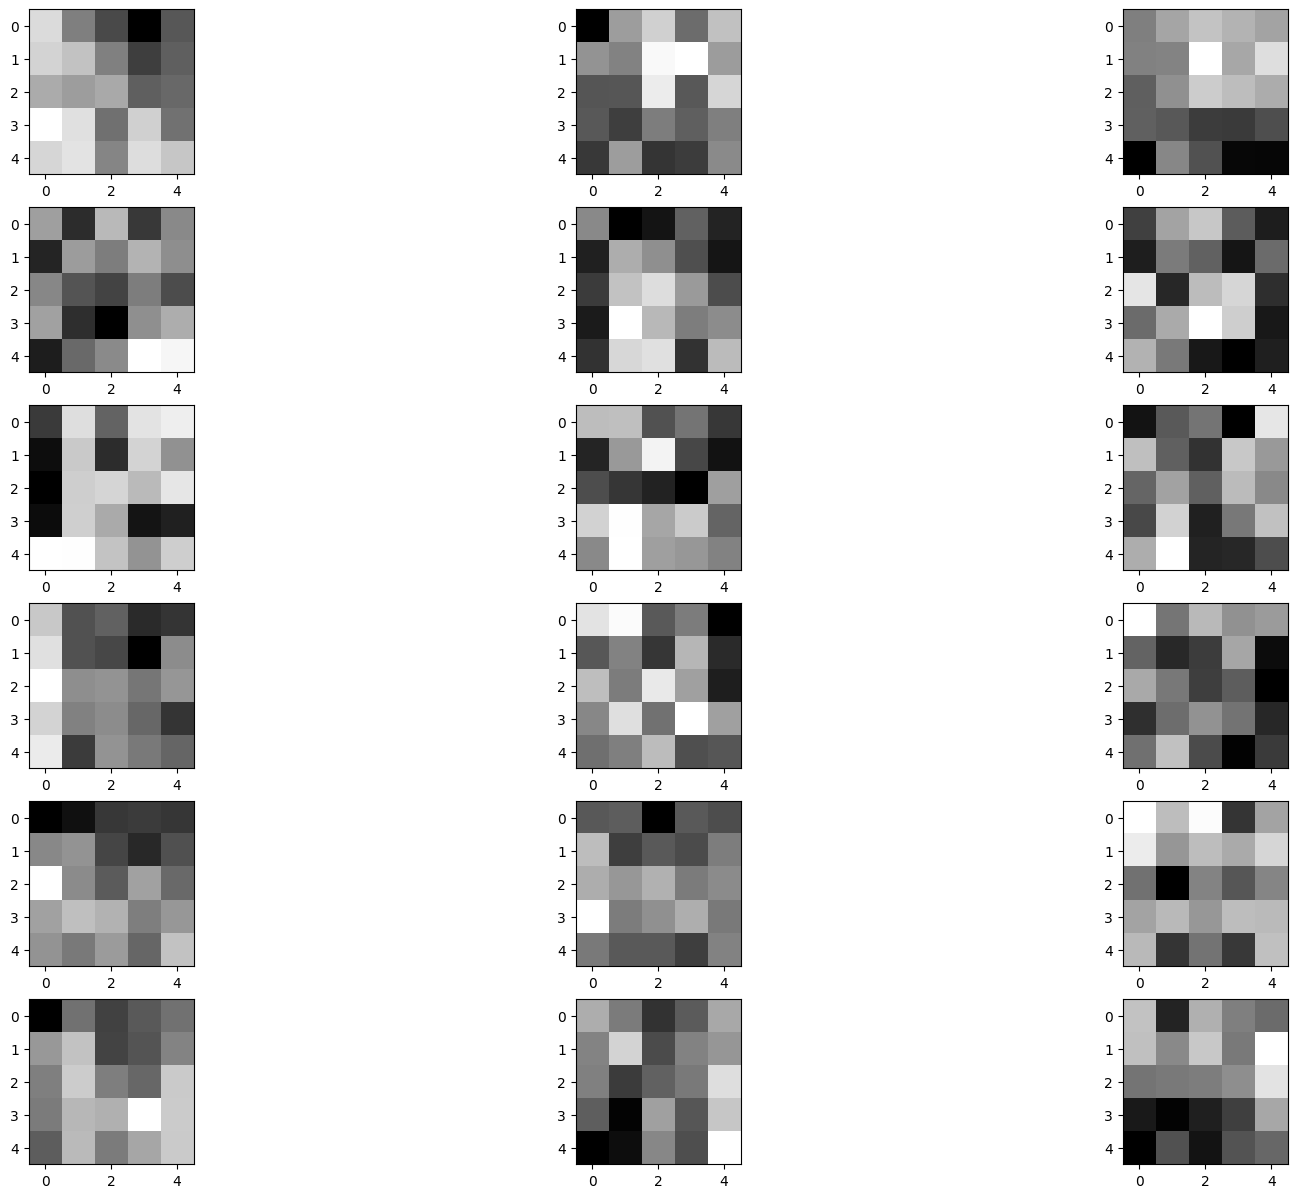

In [99]:
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [101]:
model_q2 = Model(inputs=model_1.inputs , outputs=model_1.layers[1].output)

1/1 [==============================] - 0s 26ms/step
(32, 64, 64, 16)


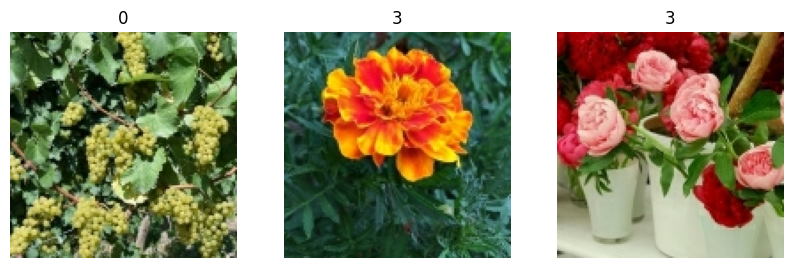

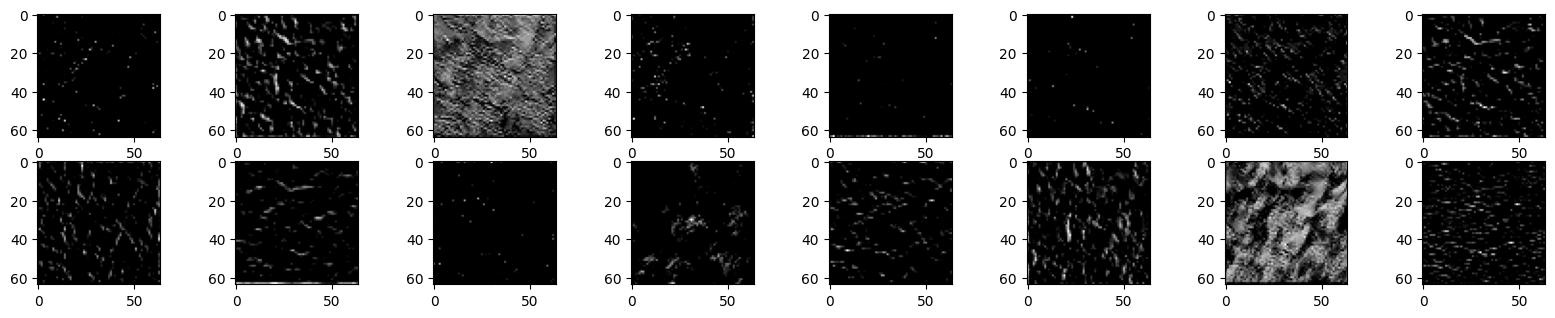

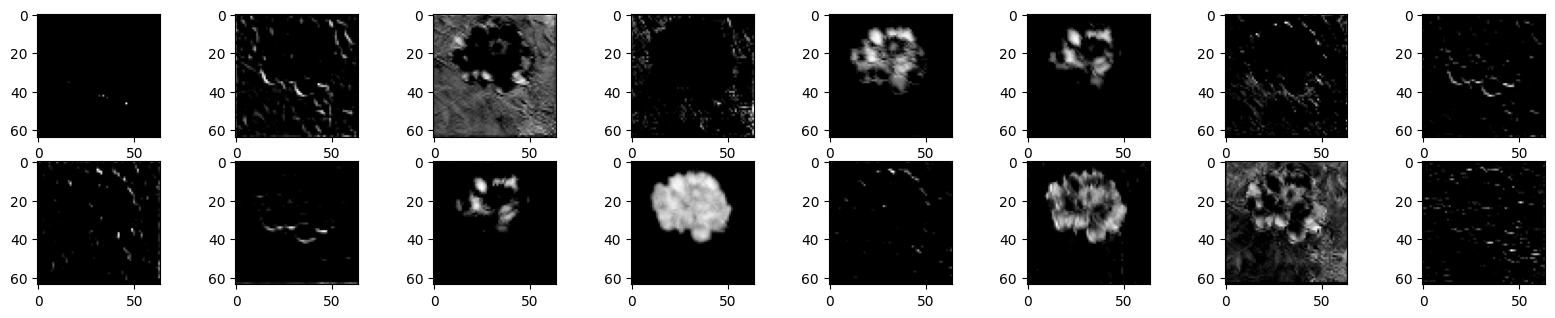

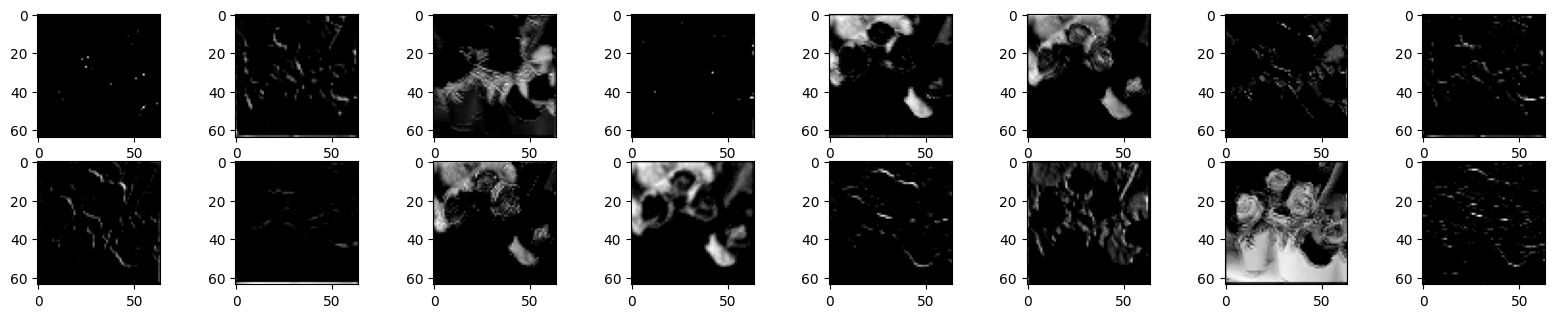

In [112]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(3):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(int(labels[i]))
#         plt.axis("off")


# print(model_1.input)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    pred_q2 = model_q2.predict(images)
    # pred_q2 = pred_q2.argmax(axis=1)
    print(pred_q2.shape)
    for j in range(3):
        fig = plt.figure(figsize=(20,15))
        for i in range(1,pred_q2.shape[3]+1):
            plt.subplot(8,8,i)
            plt.imshow(pred_q2[j,:,:,i-1] , cmap='gray')
    



# 4) 

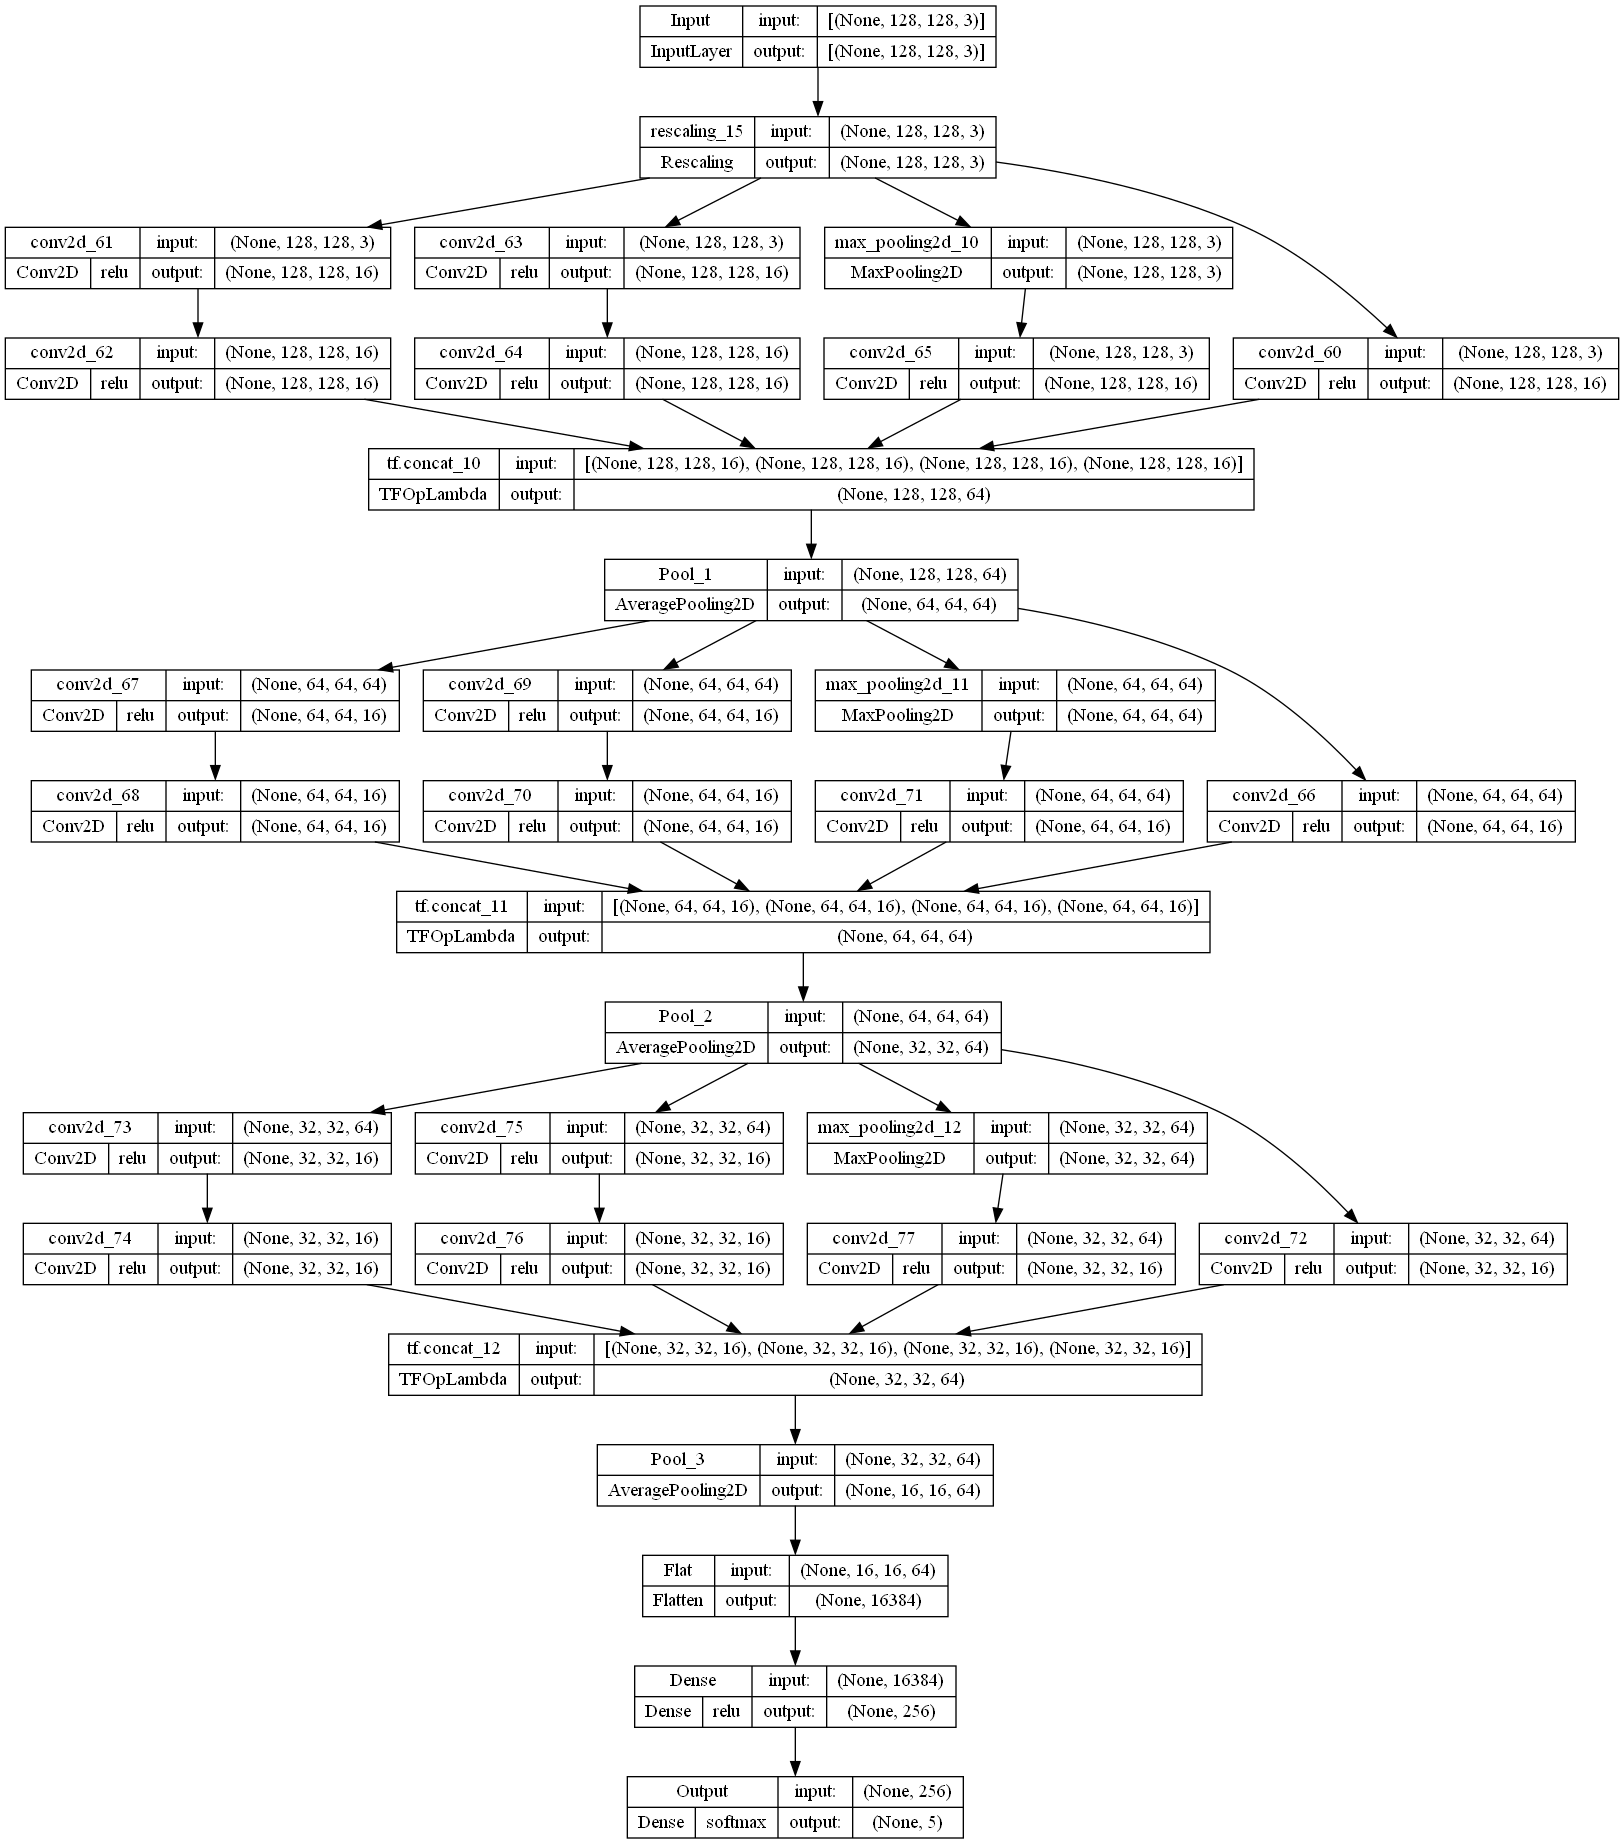

In [116]:
from tensorflow.keras import datasets, layers, models, losses, Model
kernel_numbers = [16, 64, 128]
kernel_size = 3
strides = 1
padding = 'same'
activation = 'relu'
pooling_app = 'avg'
pool_size = 2
hidden_layer = 256
dropout_enable = False
verbose = 1

def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
  path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(path2)
  path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(path3)
  path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
  return tf.concat([path1, path2, path3, path4], axis=3)

inp = Input((128, 128, 3,), name="Input")
inp_norm = tf.keras.layers.Rescaling(1./255)(inp)

conv_1_fliters = kernel_numbers[0]
conv_2_fliters = kernel_numbers[1]
conv_3_fliters = kernel_numbers[2]


conv_1 = inception(inp_norm,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters)
avg_pool_1 = AveragePooling2D(pool_size=(pool_size, pool_size), name="Pool_1")(conv_1)
conv_2 = inception(avg_pool_1,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters)
avg_pool_2 = AveragePooling2D(pool_size=(pool_size, pool_size), name="Pool_2")(conv_2)
conv_3 = inception(avg_pool_2,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters,conv_1_fliters)
avg_pool_1 = AveragePooling2D(pool_size=(pool_size, pool_size), name="Pool_3")(conv_3)



dense = (Flatten(name="Flat"))(avg_pool_1)
dense = (Dense(hidden_layer, activation="relu", name="Dense"))(dense)
output_layer = (Dense(5, activation="softmax", name="Output"))(dense)

model_4 = Model(inputs = inp, outputs = output_layer)
# model_4.summary()
keras.utils.plot_model(model_4, show_layer_activations=True, show_shapes=True, show_layer_names=True)


Epoch 1/75
169/169 [==============================] - 11s 55ms/step - loss: 1.3810 - accuracy: 0.4007 - val_loss: 1.1668 - val_accuracy: 0.4850
Epoch 2/75
169/169 [==============================] - 9s 52ms/step - loss: 1.0999 - accuracy: 0.5404 - val_loss: 1.0193 - val_accuracy: 0.5583
Epoch 3/75
169/169 [==============================] - 9s 52ms/step - loss: 0.9674 - accuracy: 0.6063 - val_loss: 0.9264 - val_accuracy: 0.6150
Epoch 4/75
169/169 [==============================] - 9s 52ms/step - loss: 0.8991 - accuracy: 0.6319 - val_loss: 0.9648 - val_accuracy: 0.6083
Epoch 5/75
169/169 [==============================] - 9s 52ms/step - loss: 0.7866 - accuracy: 0.6872 - val_loss: 0.9089 - val_accuracy: 0.6350
Epoch 6/75
169/169 [==============================] - 9s 52ms/step - loss: 0.6507 - accuracy: 0.7478 - val_loss: 0.9413 - val_accuracy: 0.6467
Epoch 7/75
169/169 [==============================] - 9s 53ms/step - loss: 0.5038 - accuracy: 0.8083 - val_loss: 1.0116 - val_accuracy: 0.625

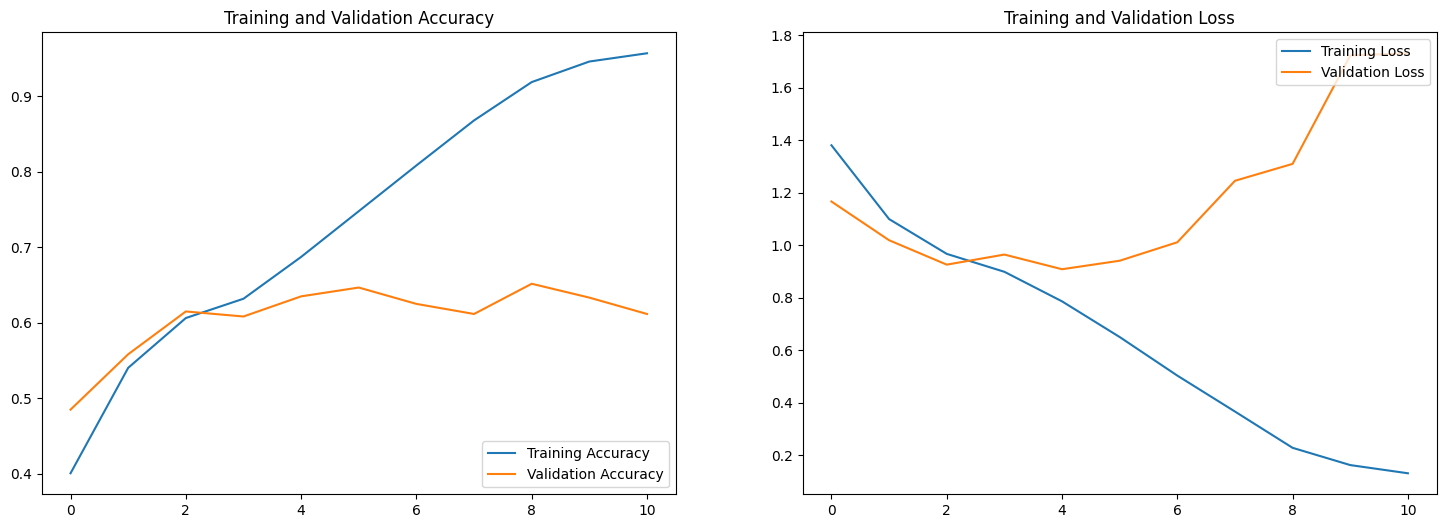

In [117]:
verbose = 1
es_callback = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
model_4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_4 = model_4.fit(train_ds, validation_data=valid_ds, epochs=75, callbacks=[es_callback],verbose=verbose)
stopped_epoch_4 = es_callback.stopped_epoch


# model_4, history_4, stopped_epoch_4 = train_cnn(kernel_numbers, kernel_size, strides, padding, activation, pooling_app, pool_size, hidden_layer, dropout_enable,verbose)

train_accu_4 = model_4.evaluate(train_ds, verbose=verbose)[1]
valid_accu_4 = model_4.evaluate(valid_ds, verbose=verbose)[1]
test_accu_4 = model_4.evaluate(test_ds, verbose=verbose)[1]
temp_res = f'kernel_numbers: {kernel_numbers}, kernel_size: {kernel_size}, strides: {strides}, padding: {padding}, activation: {activation}, pooling_app: {pooling_app}, pool_size: {pool_size}, hidden_layer: {hidden_layer}, dropout_enable: {dropout_enable}, train_accuracy = {round(train_accu_4*100, 2)}, validation_accuracy = {round(valid_accu_4*100, 2)}, test_accuracy = {round(test_accu_4*100, 2)}' 
print(temp_res)


acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs_range = range(stopped_epoch_4+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

19/19 [==============================] - 1s 27ms/step


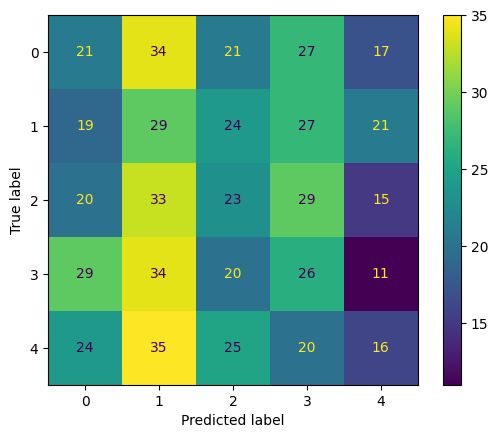

In [118]:
pred_4 = model_4.predict(valid_ds)
pred_4 = pred_4.argmax(axis=1)
cm = confusion_matrix(valid_labels, pred_4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# 6) 

## Datasets

In [119]:
data_dir_test ='../Inputs/flower_photos_data/test'     
data_dir_train ='../Inputs/flower_photos_data/train'     
data_dir_val ='../Inputs/flower_photos_data/val'     

train_ds_flower = tf.keras.utils.image_dataset_from_directory(
data_dir_train,
seed=123,
image_size=(128, 128),
batch_size=32)

valid_ds_flower = tf.keras.utils.image_dataset_from_directory(
data_dir_val,
seed=123,
image_size=(128, 128),
batch_size=32)
 
test_ds_flower = tf.keras.utils.image_dataset_from_directory(
data_dir_test,
seed=123,
image_size=(128, 128),
batch_size=32)

Found 2567 files belonging to 5 classes.
Found 731 files belonging to 5 classes.
Found 372 files belonging to 5 classes.


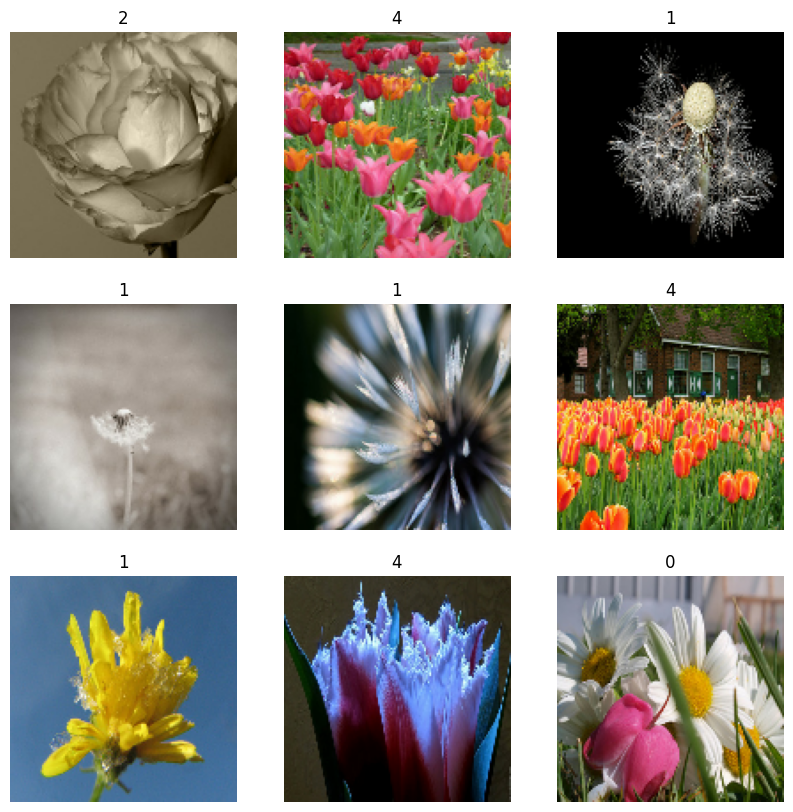

In [126]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_flower.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [127]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break
# train_ds_flower.class_names
AUTOTUNE = tf.data.AUTOTUNE

train_ds_flower = train_ds_flower.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds_flower = valid_ds_flower.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds_flower = test_ds_flower.cache().prefetch(buffer_size=AUTOTUNE)

In [128]:
model_1_backup = tf.keras.models.clone_model(model_1)
model_1_backup.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 Pool_1 (AveragePooling2D)   (None, 32, 32, 16)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 16, 16, 32)        12832     
                                                                 
 Pool_2 (AveragePooling2D)   (None, 8, 8, 32)          0         
                                                                 
 Conv_3 (Conv2D)             (None, 4, 4, 128)         102528    
                                                                 
 Pool_3 (AveragePooling2D)   (None, 2, 2, 128)        

In [158]:
model_6 = keras.Sequential([])

for layer in model_1_backup.layers:
    if 'Flat' not in layer.name and 'Dense' not in layer.name and 'Output' not in layer.name:
        model_6.add(layer)   

   
for layer in model_6.layers:
    print(layer.name)  
    if 'flat' in layer.name.lower() or 'dense' in layer.name.lower() or 'output' in layer.name.lower() or 'rescaling' in layer.name.lower() or 'pool' in layer.name.lower():
        continue    
    layer.trainable = False 

model_6_base = tf.keras.models.clone_model(model_6)


rescaling_11
Conv_1
Pool_1
Conv_2
Pool_2
Conv_3
Pool_3


In [171]:
hidden_layers = [16, 32, 64, 128, 256]
models_candidate = []
for hidden in hidden_layers:
    model_6_hid =  tf.keras.models.clone_model(model_6_base)

    model_6_hid.add(Flatten(name="Flat"))
    model_6_hid.add(Dense(hidden, activation="relu", name="Dense"))
    model_6_hid.add(Dense(5, activation="softmax", name="Output"))

    # outputs = output_layer
    model_6_hid.build(input_shape=(None,128,128,3))
    # model_6_hid.summary()


    es_callback = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    model_6_hid.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history_6_hid = model_6_hid.fit(train_ds_flower, validation_data=valid_ds_flower, epochs=15, callbacks=[es_callback],verbose=0)
    stopped_epoch_6_hid = es_callback.stopped_epoch
    models_candidate.append(model_6_hid)
    train_accu_6_hid = model_6_hid.evaluate(train_ds_flower, verbose=0)[1]
    valid_accu_6_hid = model_6_hid.evaluate(valid_ds_flower, verbose=0)[1]
    test_accu_6_hid = model_6_hid.evaluate(test_ds_flower, verbose=0)[1]
    temp_res = f'hidden_layer: {hidden}, train_accuracy = {round(train_accu_6_hid*100, 2)}, validation_accuracy = {round(valid_accu_6_hid*100, 2)}, test_accuracy = {round(test_accu_6_hid*100, 2)}' 
    print(temp_res)
    # break

hidden_layer: 16, train_accuracy = 43.28, validation_accuracy = 46.24, test_accuracy = 43.28
hidden_layer: 32, train_accuracy = 44.99, validation_accuracy = 43.23, test_accuracy = 45.97
hidden_layer: 64, train_accuracy = 49.71, validation_accuracy = 48.7, test_accuracy = 47.58
hidden_layer: 128, train_accuracy = 50.33, validation_accuracy = 47.61, test_accuracy = 48.92
hidden_layer: 256, train_accuracy = 52.12, validation_accuracy = 49.25, test_accuracy = 50.27


In [172]:
final_model_6 = models_candidate[4]
for layer in final_model_6.layers:
    print(layer.name)  
    if 'flat' in layer.name.lower() or 'dense' in layer.name.lower() or 'output' in layer.name.lower() or 'rescaling' in layer.name.lower() or 'pool' in layer.name.lower():
        continue    
    layer.trainable = True 
final_model_6.summary()

rescaling_11
Conv_1
Pool_1
Conv_2
Pool_2
Conv_3
Pool_3
Flat
Dense
Output
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 Pool_1 (AveragePooling2D)   (None, 32, 32, 16)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 16, 16, 32)        12832     
                                                                 
 Pool_2 (AveragePooling2D)   (None, 8, 8, 32)          0         
                                                                 
 Conv_3 (Conv2D)             (None, 4, 4, 128)         102528    
                                              

Epoch 1/100
81/81 [==============================] - 1s 12ms/step - loss: 0.9594 - accuracy: 0.6256 - val_loss: 0.9339 - val_accuracy: 0.6197
Epoch 2/100
81/81 [==============================] - 1s 8ms/step - loss: 0.8770 - accuracy: 0.6517 - val_loss: 0.9285 - val_accuracy: 0.6553
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 0.8568 - accuracy: 0.6642 - val_loss: 0.9107 - val_accuracy: 0.6457
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 0.7915 - accuracy: 0.6907 - val_loss: 0.9167 - val_accuracy: 0.6621
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 0.7119 - accuracy: 0.7347 - val_loss: 0.8890 - val_accuracy: 0.6689
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 0.6415 - accuracy: 0.7639 - val_loss: 0.8949 - val_accuracy: 0.6539
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 0.5587 - accuracy: 0.7881 - val_loss: 0.8710 - val_accuracy: 0.6813
Epoch 8/100


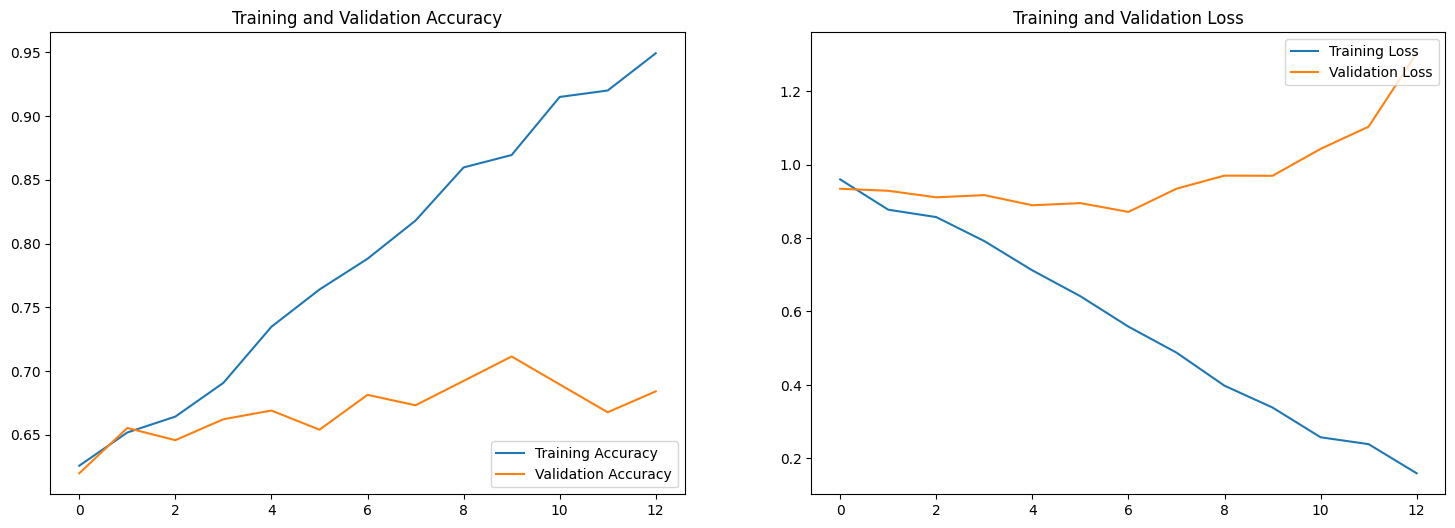

In [174]:
es_callback = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
final_model_6.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history_6_final = final_model_6.fit(train_ds_flower, validation_data=valid_ds_flower, epochs=100, callbacks=[es_callback],verbose=1)
stopped_epoch_6_final = es_callback.stopped_epoch
models_candidate.append(final_model_6)
train_accu_6_final = final_model_6.evaluate(train_ds_flower, verbose=1)[1]
valid_accu_6_final = final_model_6.evaluate(valid_ds_flower, verbose=1)[1]
test_accu_6_final = final_model_6.evaluate(test_ds_flower, verbose=1)[1]
temp_res = f'hidden_layer: {hidden}, train_accuracy = {round(train_accu_6_final*100, 2)}, validation_accuracy = {round(valid_accu_6_final*100, 2)}, test_accuracy = {round(test_accu_6_final*100, 2)}' 
print(temp_res)

acc = history_6_final.history['accuracy']
val_acc = history_6_final.history['val_accuracy']

loss = history_6_final.history['loss']
val_loss = history_6_final.history['val_loss']

epochs_range = range(stopped_epoch_6_final+1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

23/23 [==============================] - 0s 12ms/step


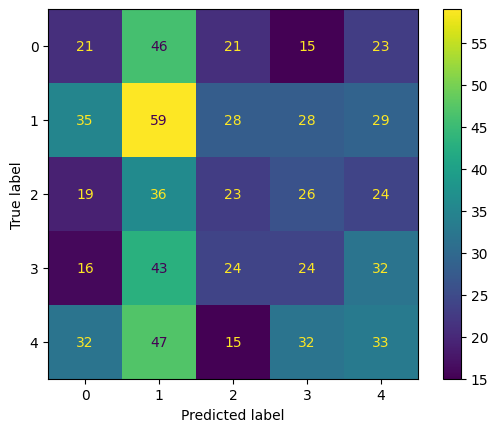

In [177]:
valid_labels_6 =  np.array([])
for _, label_batch in valid_ds_flower:
    valid_labels_6 = np.concatenate([valid_labels_6, label_batch])

pred_6 = final_model_6.predict(valid_ds_flower)
pred_6 = pred_6.argmax(axis=1)
cm = confusion_matrix(valid_labels_6, pred_6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

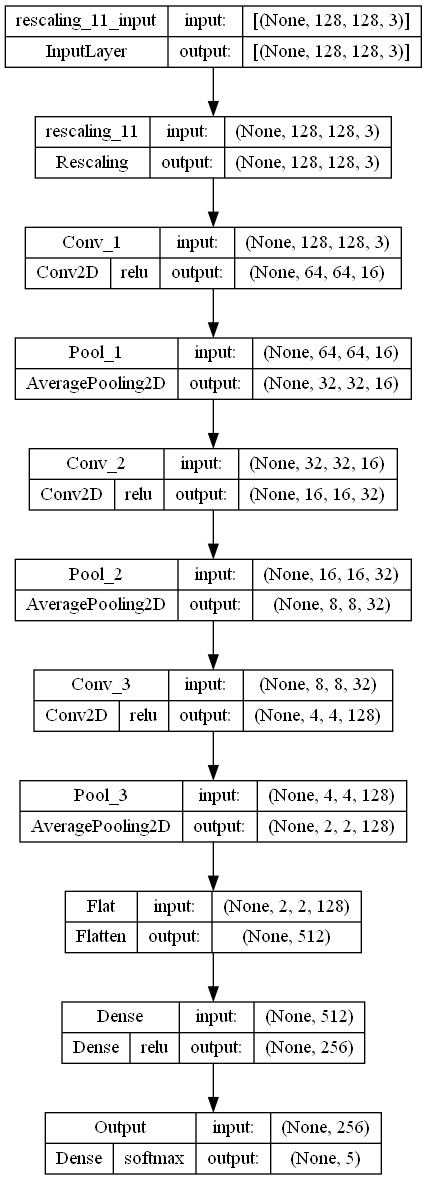

In [178]:
keras.utils.plot_model(final_model_6, show_layer_activations=True, show_shapes=True, show_layer_names=True)
